In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

## Loading data and checking the values

In [2]:
df_titanic_train = pd.read_csv('train.csv')
df_titanic_test = pd.read_csv('test.csv')
PassengerId = df_titanic_test["PassengerId"]

<font color="blue" size=3><b>Checking the outliers</b></font>

In [3]:
# Outlier detection 

def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp, Parch and Fare
outliers_to_drop = detect_outliers(df_titanic_train, 2, ["Age", "SibSp", "Parch", "Fare"])

# Outliers

df_titanic_train.loc[outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [4]:
# Drop outliers

df_titanic_train = df_titanic_train.drop(outliers_to_drop, axis = 0).reset_index(drop=True)

In [5]:
# Concatenate the two dataframes to minimize the bias and to have the same columns after feature engineering

train_size = len(df_titanic_train)
df_titanic =  pd.concat(objs=[df_titanic_train, df_titanic_test], axis=0).reset_index(drop=True)
df_titanic.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [6]:
# Filling empty values with NaN and checking the null values

df_titanic = df_titanic.fillna(np.nan)

# Survived will not be considered because the empty values are from test dataset

df_titanic.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [7]:
def absolute_relative_freq(variable):
    absolute_frequency = variable.value_counts()
    relative_frequency = round(variable.value_counts(normalize = True)*100, 2) 
    df = pd.DataFrame({'Absolute Frequency':absolute_frequency, 'Relative Frequency(%)':relative_frequency})
    print('Absolute and Relative Frequency of [',variable.name,']')
    display(df)

## Analysing the features (columns) and filling up the NaN values

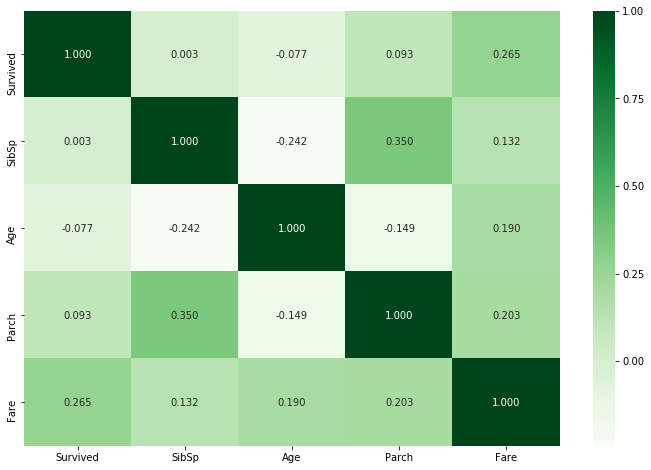

In [8]:
# Get some conclusion about the correlation among 'Survived' and SibSp, Parch, Age and Fare.

fig, ax = plt.subplots(figsize=(12,8))
g = sns.heatmap(
    df_titanic[["Survived", "SibSp", "Age", "Parch", "Fare"]].corr(),
    annot=True, 
    fmt = ".3f", 
    cmap = "Greens",
    ax=ax)

<font color="blue" size=3><b>Fare has a low correlation with Survived, but if we compare to the others features, this is more relevant.</b></font>

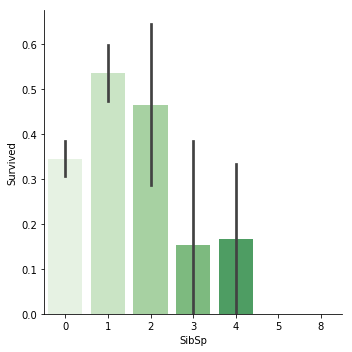

In [9]:
# View the proportion between SibSp and Survived

g = sns.factorplot(x="SibSp", 
                   y="Survived", 
                   data=df_titanic, 
                   kind="bar", 
                   size=5, 
                   palette = "Greens")

g = g.set_ylabels("Survived")

<font color="blue" size=3><b>Passengers with many siblings/spouses have less chances to survive (more than 2). Passengers that are alone or with 1 or 2 siblings/spouses have more chances to survive.</b></font>

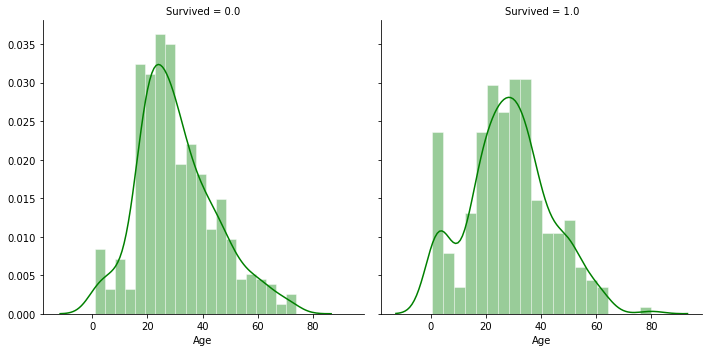

In [10]:
# View the distribution of Age

g = sns.FacetGrid(df_titanic, 
                  col='Survived', 
                  height=5, 
                  aspect=1)

g = g.map(sns.distplot, "Age", 
          bins=20, 
          color='g', 
          hist_kws=dict(edgecolor="w", linewidth=1))

<font color="blue" size=3><b>Younger passengers had more chance to survive and older ones had less chances to get saved. Passengers that are between 20 and 40 sometimes had chances to survive or not.</b></font>

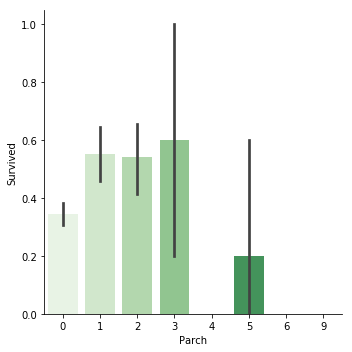

In [11]:
# View the proportion between Parch and Survived

g = sns.factorplot(x="Parch", 
                   y="Survived", 
                   data=df_titanic, 
                   kind="bar", 
                   size=5, 
                   palette = "Greens")

g = g.set_ylabels("Survived")

<font color="blue" size=3><b>Passengers with 1 or 2 parents/children had more chances to survive. Passengers with 3 parents/children had good chances to survive in this dataset, but we can see a large variance.</b></font>

In [12]:
# Filling with the median the only one Fare equals to NaN

df_titanic['Fare'] = df_titanic['Fare'].fillna(df_titanic['Fare'].median())

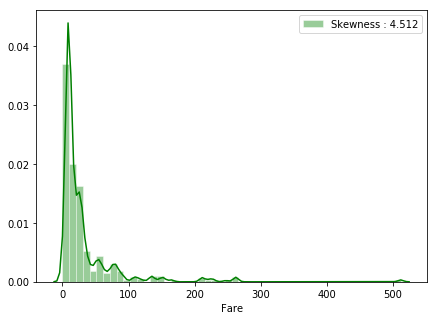

In [13]:
# Viewing the Fare distribution
 
fig, ax = plt.subplots(figsize=(7,5))
g = sns.distplot(df_titanic["Fare"], 
                 color="g", 
                 label="Skewness : %.3f"%(df_titanic["Fare"].skew()), 
                 hist_kws=dict(edgecolor="w", linewidth=1),
                 ax=ax)
                 
g = g.legend(loc="best")

<font color="blue" size=3><b>Fare distribution is very skewed to the right. Let's use the log function to minimize this skewness.</b></font>

In [14]:
df_titanic["Fare"] = df_titanic["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

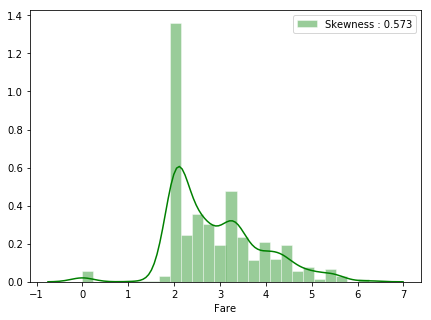

In [15]:
# Viewing the Fare distribution after applying log function
 
fig, ax = plt.subplots(figsize=(7,5))
g = sns.distplot(df_titanic["Fare"], 
                 color="g", 
                 label="Skewness : %.3f"%(df_titanic["Fare"].skew()), 
                 hist_kws=dict(edgecolor="w", linewidth=1),
                 ax=ax)
                 
g = g.legend(loc="best")

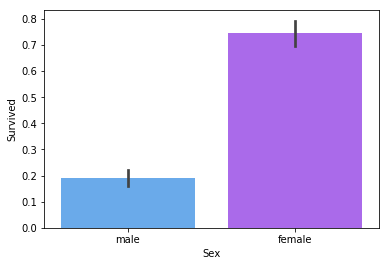

In [16]:
# View the proportion between Sex and Survived

g = sns.barplot(x="Sex", y="Survived",data=df_titanic, palette='cool')
g = g.set_ylabel("Survived")

In [17]:
absolute_relative_freq(df_titanic['Sex'])

Absolute and Relative Frequency of [ Sex ]


,Absolute Frequency,Relative Frequency(%)
male,838,64.51
female,461,35.49


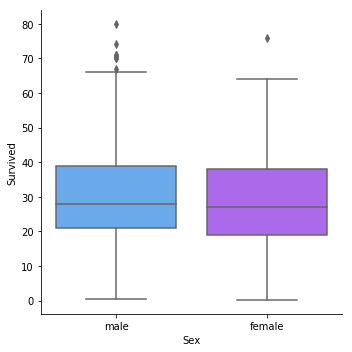

In [18]:
# View the relationship between Sex and Age

g = sns.factorplot(x="Sex", 
                   y="Age", 
                   data=df_titanic, 
                   kind="box", 
                   size=5, 
                   palette = "cool")

g = g.set_ylabels("Survived")

<font color="blue" size=3><b>According to the first plot, women had more chances than men to survive. There is a very irrelevant difference between the median age of men and women (approximately the same value).</b></font>

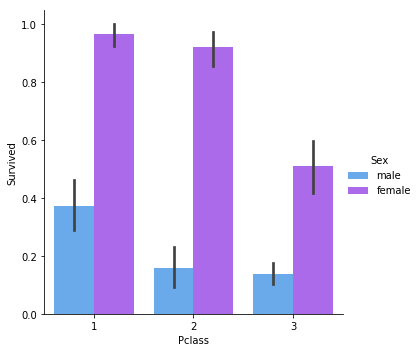

In [19]:
# View the proportion between Pclass, Sex and Survived

g = sns.factorplot(x="Pclass", 
                   y="Survived", 
                   data=df_titanic,
                   hue='Sex',
                   kind="bar", 
                   size=5, 
                   palette = "cool")

g = g.set_ylabels("Survived")

<font color="blue" size=3><b>Passengers in the first class had more chances to survive, following by second class and third one. Again, women had more chances to survive in the 3 classes.</b></font>

In [20]:
absolute_relative_freq(df_titanic['Pclass'])

Absolute and Relative Frequency of [ Pclass ]


,Absolute Frequency,Relative Frequency(%)
3,702,54.04
1,320,24.63
2,277,21.32


In [21]:
df_titanic['Embarked'].value_counts()

S    904
C    270
Q    123
Name: Embarked, dtype: int64

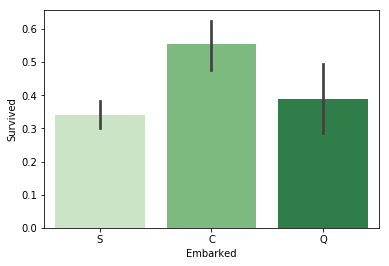

In [22]:
# View the proportion between Embarked and Survived

# Filling the NaN value with 'S' (more frequent city)

df_titanic['Embarked'].fillna('S', inplace=True)

g = sns.barplot(x="Embarked", y="Survived",data=df_titanic, palette='Greens')
g = g.set_ylabel("Survived")

<font color="blue" size=3><b>Passengers that embarked in Cherbourg had more chances to survive than the other.</b></font>

In [23]:
absolute_relative_freq(df_titanic['Embarked'])

Absolute and Relative Frequency of [ Embarked ]


,Absolute Frequency,Relative Frequency(%)
S,906,69.75
C,270,20.79
Q,123,9.47


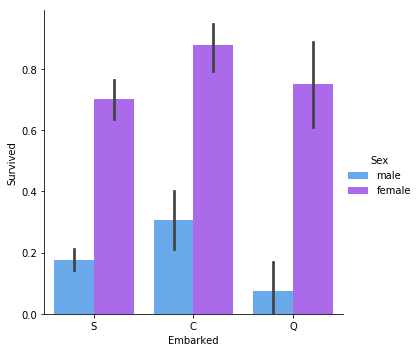

In [24]:
# View the proportion between Embarked, Sex and Survived

g = sns.factorplot(x="Embarked", 
                   y="Survived", 
                   data=df_titanic,
                   hue='Sex',
                   kind="bar", 
                   size=5, 
                   palette = "cool")

g = g.set_ylabels("Survived")

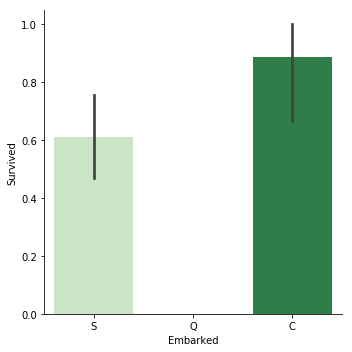

In [25]:
# View the proportion between Embarked, Age less than 10 and Survived

g = sns.factorplot(x="Embarked", 
                   y="Survived", 
                   data=df_titanic[df_titanic['Age'] < 10] ,
                   kind="bar", 
                   size=5, 
                   palette = "Greens")

g = g.set_ylabels("Survived")

<font color="blue" size=3><b>As we saw previously, younger passengers have more chances to survive. Those kids that embarked in Chesbourg (mainly) and Southampton had good chances to survive. Chesbourg had more women and kids, so we can explain many survivors from there. Let's see the proportion with Pclass.</b></font>

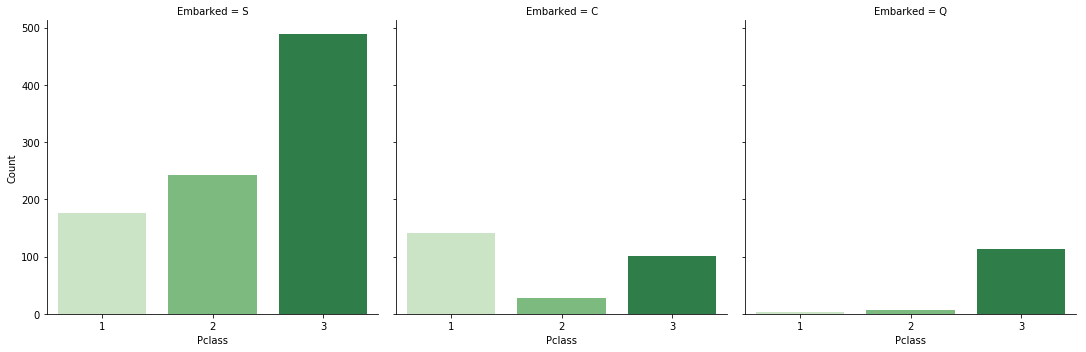

In [26]:
# View the proportion between Pclass and Embarked

g = sns.factorplot("Pclass",
                   col="Embarked",
                   data=df_titanic,
                   size=5, 
                   kind="count", 
                   palette="Greens")

g = g.set_ylabels("Count")

In [27]:
labelEncoder = LabelEncoder()
df_titanic['Embarked'] = labelEncoder.fit_transform(df_titanic['Embarked'])

<font color="blue" size=3><b>Chesbourg had more passengers in first class compared to second and third one. Good explanation to have more survivors. And Southampton had a large number of passengers in third class explaining less survivors if we compared to the other cities.</b></font>

<font color="blue" size=3><b>We still have some rows with NaN Age.Let's try to figure out one correlation among Age and other columns.</b></font>

In [28]:
df_titanic['Age'].isnull().sum()

256

In [29]:
labelEncoder = LabelEncoder()
df_titanic['Sex'] = labelEncoder.fit_transform(df_titanic['Sex'])

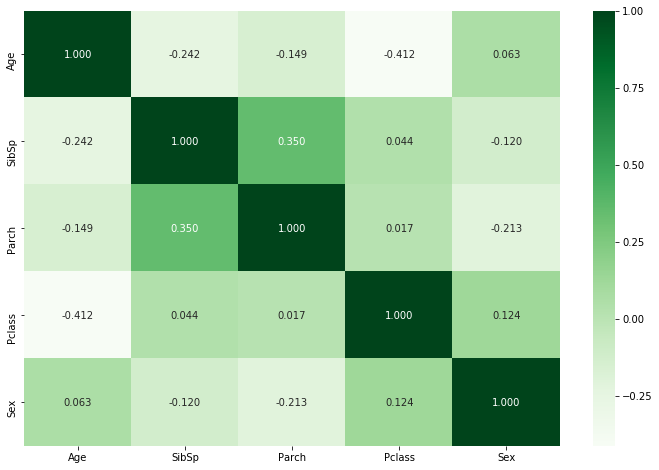

In [30]:
fig, ax = plt.subplots(figsize=(12,8))
g = sns.heatmap(
    df_titanic[["Age", "SibSp", "Parch", "Pclass", "Sex"]].corr(),
    annot=True, 
    fmt = ".3f", 
    cmap = "Greens",
    ax=ax)

<font color="blue" size=3><b>As we got in the boxplot some cells behind, Age has a very small correlation with Sex (median age is practically the same). Pclass, SibSp and Parch have better correlations with Sex respectively. The rows with Age equals to NaN will be filled by the median value of similar rows (the same Pclass and SibSp) - two more correlated with Age.</b></font>

In [31]:
df_titanic['Age'].isnull().sum()

256

In [32]:
# Rows with Age equals to NaN

condition = df_titanic['Age'].isnull()
age_NaN = df_titanic['Age'][condition].index

for age in age_NaN :
    
    # Conditions
    
    condition1 = df_titanic['SibSp'] == df_titanic.iloc[age]["SibSp"]
    condition2 = df_titanic['Pclass'] == df_titanic.iloc[age]["Pclass"]
    condition3 = df_titanic['Parch'] == df_titanic.iloc[age]["Parch"]
    condition = condition1 & condition2 & condition3
    
    new_age = df_titanic['Age'][condition].median()
    df_titanic['Age'].iloc[age] = new_age if not np.isnan(new_age) else df_titanic['Age'].median()

In [33]:
df_titanic['Age'].isnull().sum()

0

In [34]:
df_titanic['Age'] = (df_titanic['Age'] - df_titanic['Age'].mean()) / df_titanic['Age'].std()

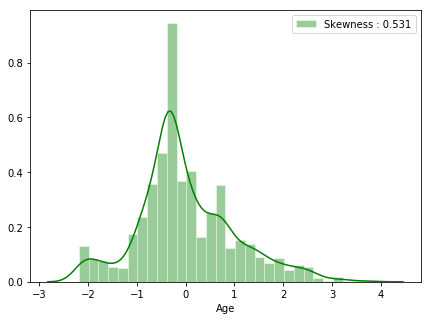

In [35]:
# Viewing the Age distribution
 
fig, ax = plt.subplots(figsize=(7,5))
g = sns.distplot(df_titanic["Age"], 
                 color="g", 
                 label="Skewness : %.3f"%(df_titanic["Age"].skew()), 
                 hist_kws=dict(edgecolor="w", linewidth=1),
                 ax=ax)
                 
g = g.legend(loc="best")

## Creating and adjusting features

<font color="blue" size=3><b>Titles and Surnames</b></font>

In [36]:
df_titanic['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [37]:
# Getting the titles from Name feature

df_titanic['Title'] = df_titanic['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df_titanic['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [38]:
# Replace the values to new categories and converting the new feature to numeric

df_titanic['Title'] = df_titanic['Title'].replace(['Don', 'Rev', 'Dr', 'Major', 'Lady', 'Sir', 
                                                   'Col', 'Capt', 'Countess', 'Jonkheer', 'Dona'], 'Rare')

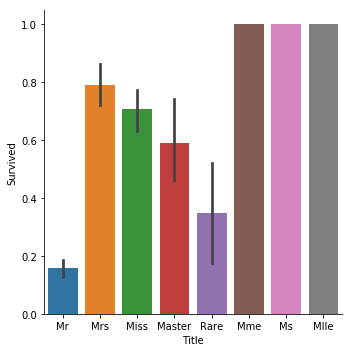

In [39]:
# View the proportion between Title and Survived

g = sns.factorplot(x="Title", 
                   y="Survived", 
                   data=df_titanic,
                   kind="bar", 
                   size=5)

g = g.set_ylabels("Survived")

<font color="blue" size=3><b>Again we can see that women had more chances to survive. Rare titles had more chances than Mister and less than Master.</b></font>

In [40]:
absolute_relative_freq(df_titanic['Title'])

Absolute and Relative Frequency of [ Title ]


,Absolute Frequency,Relative Frequency(%)
Mr,753,57.97
Miss,255,19.63
Mrs,197,15.17
Master,60,4.62
Rare,29,2.23
Ms,2,0.15
Mlle,2,0.15
Mme,1,0.08


In [41]:
df_titanic["Title"] = df_titanic['Title'].map({"Master":0, "Miss":1, "Ms" : 1, "Mme":1, 
                                               "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})

df_titanic['Title'] = df_titanic["Title"].astype(int)

In [42]:
# Creating a column with the Surname

df_titanic['Surname'] = df_titanic['Name'].map(lambda i: i.split(',')[0])

In [43]:
# Deleting Name

del df_titanic['Name']

<font color="blue" size=3><b>Cabin</b></font>

In [44]:
df_titanic['Cabin'].isnull().sum()

1007

In [45]:
df_titanic['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'B78', 'D33',
       'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31', 'A5', 'D10 D12',
       'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47', 'B86', 'F2',
       'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4', 'B80', 'A31',
       'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77', 'E67', 'B94',
       'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D', 'C22 C26', 'C106',
       'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18',
       'C124', 'C91', 'E40', 'T', 'C128', 'D37', 'B35', 'E50', 'C82',
       'B96 B98', 'E10', 'E44', 'C23 C25 C27', 'A34', 'C104', 'C111',
       'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20',
       'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86',
       'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19',
       'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71',
       'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24',

<font color="blue" size=3><b>All cabins start with a letter, so let's simplyfing their values.</b></font>

In [46]:
df_titanic['Cabin'] = df_titanic['Cabin'].map(lambda i: i[0] if not pd.isnull(i) else 'Z')
df_titanic['Cabin'].unique()

array(['Z', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

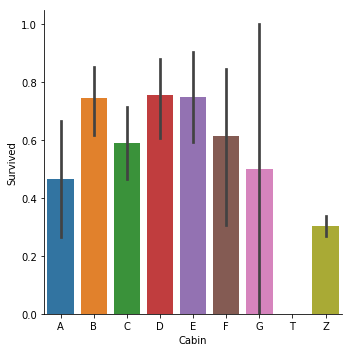

In [47]:
# View the proportion between Cabin and Survived

g = sns.factorplot(x="Cabin", 
                   y="Survived", 
                   data=df_titanic,
                   kind="bar", 
                   size=5, 
                   order=['A','B','C','D','E','F','G','T','Z'])

g = g.set_ylabels("Survived")

<font color="blue" size=3><b>Passengers with no cabin had less chances to survive.</b></font>

In [48]:
absolute_relative_freq(df_titanic['Cabin'])

Absolute and Relative Frequency of [ Cabin ]


,Absolute Frequency,Relative Frequency(%)
Z,1007,77.52
C,91,7.01
B,65,5.00
D,46,3.54
E,41,3.16
A,22,1.69
F,21,1.62
G,5,0.38
T,1,0.08


<font color="blue" size=3><b>Tickets</b></font>

In [49]:
df_titanic['Ticket'].unique()

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '330959', '349216', 'PC 17601', 'PC 17569',
       '335677', 'C.A. 24579', 'PC 17604', '113789', '2677', 'A./5. 2152',
       '345764', '2651', '7546', '11668', '349253', 'SC/Paris 2123',
       '330958', 'S.C./A.4. 23567', '370371', '14311', '2662', '349237',
       '3101295', 'A/4. 39886', 'PC 17572', '2926', '113509', '19947',
       'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144', '2669', '113572',
       '36973', '347088', 'PC 17605', '2661', 'C.A. 29395', 'S.P. 3464',
       '3101281', '315151', 'C.A. 33111', 'S.O.C. 14879', '2680', '1601',
       '348123', '349208', '374746', '248738', '364516', '345767',
       '345779', '330932', '113059', 'SO/C 14885', '3101278',
       'W./

In [50]:
# Getting the first information of the ticket

df_titanic['Ticket'] = df_titanic['Ticket'].map(
    lambda i: i.replace(".","").replace("/","").strip().split(' ')[0] if not i.isdigit() else "TKT")

In [51]:
df_titanic['Ticket'].unique()

array(['A5', 'PC', 'STONO2', 'TKT', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

<font color="blue" size=3><b>Family (SibSp, Parch)</b></font>

In [52]:
df_titanic['Family'] = df_titanic['SibSp'] + df_titanic['Parch'] + 1

In [53]:
df_titanic['Family'].unique()

array([ 2,  1,  5,  3,  7,  6,  4,  8, 11])

In [54]:
# Creating new features: 
#   1: Alone
#   2: Small family
#   3 to 4: Medium family
#   larger than 5: Large family

df_titanic['Alone'] = df_titanic['Family'].map(lambda i: 1 if i == 1 else 0)
df_titanic['Small'] = df_titanic['Family'].map(lambda i: 1 if i == 2 else 0)
df_titanic['Medium'] = df_titanic['Family'].map(lambda i: 1 if 3 <= i <= 4 else 0)
df_titanic['Large'] = df_titanic['Family'].map(lambda i: 1 if i >= 5 else 0)

<font color="blue" size=3><b>Creating dummies features</b></font>

In [55]:
df_titanic.head()

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Surname,Family,Alone,Small,Medium,Large
0,-0.548204,Z,2,1.981001,0,1,3,1,1,0.0,A5,2,Braund,2,0,1,0,0
1,0.657412,C,0,4.266662,0,2,1,0,1,1.0,PC,1,Cumings,2,0,1,0,0
2,-0.246800,Z,2,2.070022,0,3,3,0,0,1.0,STONO2,1,Heikkinen,1,1,0,0,0
3,0.431359,C,2,3.972177,0,4,1,0,1,1.0,TKT,1,Futrelle,2,0,1,0,0
4,0.431359,Z,2,2.085672,0,5,3,1,0,0.0,TKT,2,Allen,1,1,0,0,0


In [56]:
# df_titanic['Title'] = df_titanic['Title'].astype("category")
df_titanic['Pclass'] = df_titanic['Pclass'].astype("category")

# Creating dummies...

columns = ['Title', 'Surname', 'Cabin', 'Ticket', 'Pclass']
for col in columns:
    df_titanic = pd.get_dummies(df_titanic, columns=[col], prefix=col)

In [57]:
df_titanic.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [58]:
df_titanic.head()

,Age,Embarked,Fare,Parch,Sex,SibSp,Survived,Family,Alone,Small,...,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_TKT,Ticket_WC,Ticket_WEP,Pclass_1,Pclass_2,Pclass_3
0,-0.548204,2,1.981001,0,1,1,0.0,2,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0.657412,0,4.266662,0,0,1,1.0,2,0,1,...,0,0,0,0,0,0,0,1,0,0
2,-0.246800,2,2.070022,0,0,0,1.0,1,1,0,...,0,1,0,0,0,0,0,0,0,1
3,0.431359,2,3.972177,0,0,1,1.0,2,0,1,...,0,0,0,0,1,0,0,1,0,0
4,0.431359,2,2.085672,0,1,0,0.0,1,1,0,...,0,0,0,0,1,0,0,0,0,1


## Creating and testing the models

In [59]:
df_titanic_train = df_titanic[:train_size]
df_titanic_test = df_titanic[train_size:]

df_titanic_train['Survived'] = df_titanic_train['Survived'].astype(int)
del df_titanic_test['Survived']

In [60]:
X_train = df_titanic_train.drop(['Survived'], axis=1)
y_train = df_titanic_train['Survived']
X_test = df_titanic_test

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [61]:
print(X_train.shape)
print(X_test.shape)

(881, 939)
(418, 939)


In [62]:
# Validation of the model with Kfold stratified splitting the data into 10 parts

kfold = StratifiedKFold(n_splits=10)

seed = 20

# List of classifiers to test

clfs = []
clfs.append(SVC(random_state=seed))
clfs.append(DecisionTreeClassifier(random_state=seed))
clfs.append(RandomForestClassifier(random_state=seed))
clfs.append(ExtraTreesClassifier(random_state=seed))
clfs.append(GradientBoostingClassifier(random_state=seed))
clfs.append(MLPClassifier(random_state=seed))
clfs.append(KNeighborsClassifier())
clfs.append(LogisticRegression(random_state=seed))
clfs.append(XGBClassifier(random_state = seed))

In [63]:
# Getting all results from 10 validations for each classifier

clf_results = []
for clf in clfs :
    clf_results.append(cross_val_score(clf, X_train, y=y_train, scoring = "accuracy", cv=kfold, n_jobs=1))

In [64]:
# Getting the mean and standard deviation from each classifier's result after 10 validations

clf_means = []
clf_std = []
for clf_result in clf_results:
    clf_means.append(clf_result.mean())
    clf_std.append(clf_result.std())

In [65]:
# Let's see which are the best scores

df_result = pd.DataFrame({"Means":clf_means, 
                          "Stds": clf_std, 
                          "Algorithm":["SVC", 
                                       "DecisionTree", 
                                       "RandomForest",
                                       "ExtraTrees",
                                       "GradientBoosting",
                                       "MLPClassifier",
                                       "KNeighboors",
                                       "LogisticRegression", 
                                       "XGBoost"]})

df_result.sort_values(by=['Means'], ascending=False)

,Algorithm,Means,Stds
3,ExtraTrees,0.830912,0.036591
4,GradientBoosting,0.830861,0.036506
8,XGBoost,0.824081,0.045449
1,DecisionTree,0.822944,0.041891
2,RandomForest,0.817275,0.043445
7,LogisticRegression,0.814951,0.032708
0,SVC,0.777554,0.043311
5,MLPClassifier,0.747957,0.047854
6,KNeighboors,0.478818,0.084199


In [66]:
# Plotting learning curves of the algorithms
#------------------------------------------------------------------------------------------------
# Code from http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
#------------------------------------------------------------------------------------------------

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 20)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [67]:
# Logistic Regression, XGBoost, Gradient Boosting, Random Forest, Extra Trees

extraTrees = ExtraTreesClassifier(random_state=seed)
gBoosting = GradientBoostingClassifier(random_state=seed)
randomForest = RandomForestClassifier(random_state=seed)
logReg = LogisticRegression(random_state=seed)
xgbc = XGBClassifier(random_state=seed)

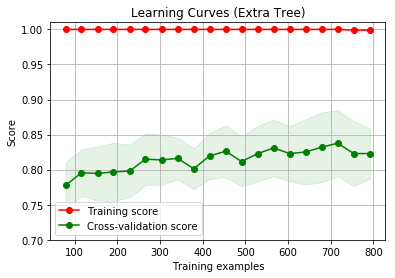

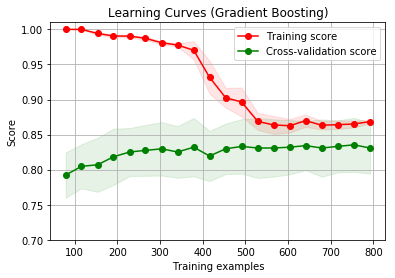

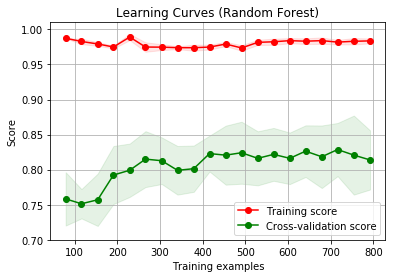

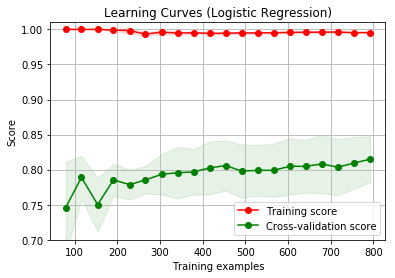

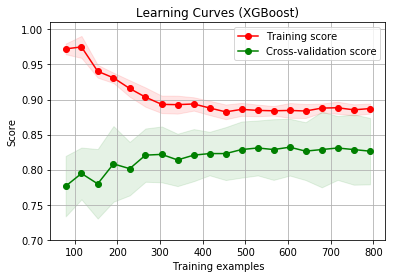

In [68]:
clfs = []
clfs.append(extraTrees)
clfs.append(gBoosting)
clfs.append(randomForest)
clfs.append(logReg)
clfs.append(xgbc)

titles = ['Learning Curves (Extra Tree)', 'Learning Curves (Gradient Boosting)',
          'Learning Curves (Random Forest)', 'Learning Curves (Logistic Regression)',
          'Learning Curves (XGBoost)']

for clf, title in zip(clfs, titles):
    plot_learning_curve(clf, title, X_train, y_train, ylim=(0.7, 1.01), cv=kfold, n_jobs=1);

<font color="blue" size=3><b>Getting the best parameters for classifiers.</b></font>

In [69]:
## Search grid for optimal parameters (Extra Trees)

param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


grid_result = GridSearchCV(extraTrees,
                      param_grid = param_grid, 
                      cv=kfold, 
                      scoring="accuracy", 
                      n_jobs= -1, 
                      verbose = 1)

grid_result.fit(X_train,y_train)

extraTrees_best_result = grid_result.best_estimator_

# Best score
print('Best score:', np.round(grid_result.best_score_*100, 2))

# Best estimator
print('Best estimator:', extraTrees_best_result)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  6.5min finished


Best score: 83.88
Best estimator: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=10, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=20, verbose=0, warm_start=False)


In [70]:
## Search grid for optimal parameters (Gradient Boosting)

param_grid = {'learning_rate': [0.01, 0.02],
              'max_depth': [4, 5, 6],
              'max_features': [0.2, 0.3, 0.4], 
              'min_samples_split': [2, 3, 4],
              'random_state':[seed]}

grid_result = GridSearchCV(gBoosting, 
                           param_grid=param_grid, 
                           cv=kfold, 
                           scoring="accuracy", 
                           n_jobs=-1,
                           verbose=1)

grid_result.fit(X_train, y_train)

gBoosting_best_result = grid_result.best_estimator_

# Best score
print('Best score:', np.round(grid_result.best_score_*100, 2))

# Best estimator
print('Best estimator:', gBoosting_best_result)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 15.1min finished


Best score: 83.65
Best estimator: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.02, loss='deviance', max_depth=4,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=20, subsample=1.0, verbose=0,
              warm_start=False)


In [71]:
## Search grid for optimal parameters (Random Forest)

param_grid = {"max_depth": [None],
              "max_features": [1, 2],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

grid_result = GridSearchCV(randomForest, 
                           param_grid=param_grid, 
                           cv=kfold, 
                           scoring="accuracy", 
                           n_jobs= -1,
                           verbose = 1)

grid_result.fit(X_train, y_train)

randomForest_best_result = grid_result.best_estimator_

# Best score
print('Best score:', np.round(grid_result.best_score_*100, 2))

# Best estimator
print('Best estimator:', randomForest_best_result)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.9min finished


Best score: 82.86
Best estimator: RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=20, verbose=0, warm_start=False)


In [72]:
## Search grid for optimal parameters (Logistic Regression)

param_grid = {'penalty' : ['l1', 'l2'],
              'C': np.logspace(0, 4, 10),
              'solver' : ['liblinear', 'saga']
              }

grid_result = GridSearchCV(logReg, 
                           param_grid=param_grid, 
                           cv=kfold, 
                           scoring="accuracy", 
                           n_jobs= -1,
                           verbose = 1)

grid_result.fit(X_train, y_train)

logReg_best_result = grid_result.best_estimator_

# Best score
print('Best score:', np.round(grid_result.best_score_*100, 2))

# Best estimator
print('Best estimator:', logReg_best_result)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  9.6min finished


Best score: 83.09
Best estimator: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=20, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [73]:
## Search grid for optimal parameters (XGBoost)

param_grid = {'n_estimators': [275, 280],
              'learning_rate': [0.01, 0.03],
              'subsample': [0.9, 1],
              'max_depth': [3, 4],
              'colsample_bytree': [0.8, 0.9],
              'min_child_weight': [2, 3],
              'random_state':[seed]}

grid_result = GridSearchCV(xgbc, 
                           param_grid=param_grid, 
                           cv=kfold, 
                           scoring="accuracy", 
                           n_jobs= -1,
                           verbose = 1)

grid_result.fit(X_train, y_train)

xgbc_best_result = grid_result.best_estimator_

# Best score
print('Best score:', np.round(grid_result.best_score_*100, 2))

# Best estimator
print('Best estimator:', xgbc_best_result)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed: 44.6min finished


Best score: 83.65
Best estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=4, min_child_weight=3, missing=None, n_estimators=275,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=20, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)


## Retrain models and check precision, recall, specificity and F1 Score

In [74]:
# List of classifiers to retrain

clfs = []
clfs.append(extraTrees_best_result)
clfs.append(gBoosting_best_result)
clfs.append(randomForest_best_result)
clfs.append(logReg_best_result)
clfs.append(xgbc_best_result)

# Getting all results from 10 validations for each classifier

clf_results = []
for clf in clfs :
    clf_results.append(cross_val_score(clf, X_train, y=y_train, scoring = "accuracy", cv=kfold, n_jobs=1))

# Getting the mean and standard deviation from each classifier's result after 10 validations

clf_means = []
clf_std = []
for clf_result in clf_results:
    clf_means.append(clf_result.mean())
    clf_std.append(clf_result.std())

# Let's see which are the best scores

df_result = pd.DataFrame({"Means":clf_means, 
                          "Stds": clf_std, 
                          "Algorithm":["Extra Trees",
                                       "GradientBoosting",
                                       "Random Forest",
                                       "LogisticRegression", 
                                       "XGBoost"]})

df_result.sort_values(by=['Means'], ascending=False)

,Algorithm,Means,Stds
0,Extra Trees,0.838853,0.031851
4,XGBoost,0.836593,0.044446
1,GradientBoosting,0.836530,0.040469
3,LogisticRegression,0.830861,0.034693
2,Random Forest,0.828639,0.045986


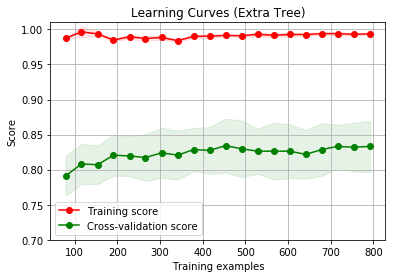

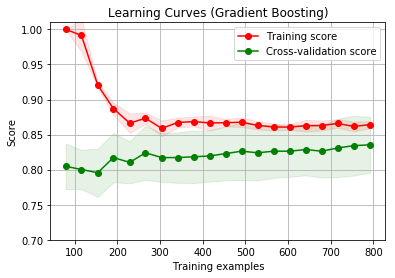

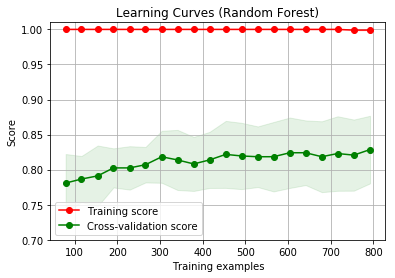

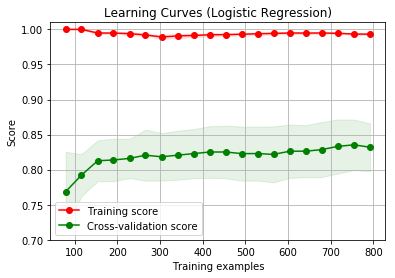

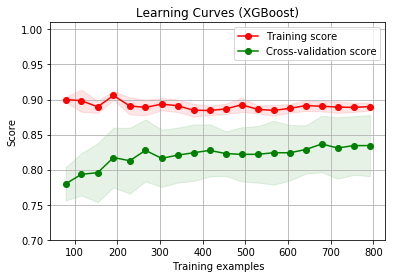

In [75]:
titles = ['Learning Curves (Extra Tree)', 'Learning Curves (Gradient Boosting)',
          'Learning Curves (Random Forest)', 'Learning Curves (Logistic Regression)',
          'Learning Curves (XGBoost)']

for clf, title in zip(clfs, titles):
    plot_learning_curve(clf, title, X_train, y_train, ylim=(0.7, 1.01), cv=kfold, n_jobs=1);

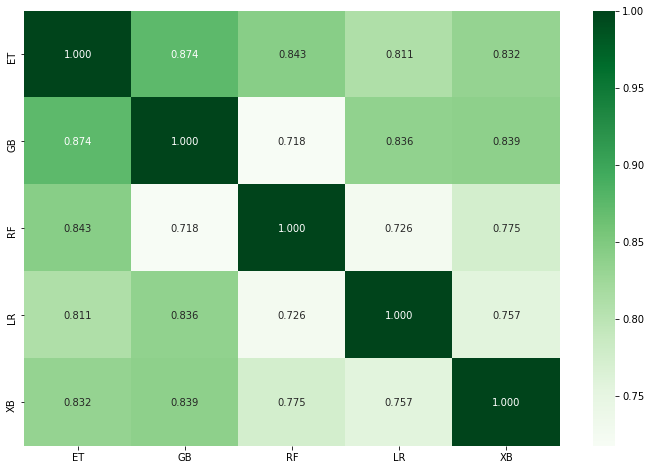

In [77]:
survived_ET = pd.Series(extraTrees_best_result.predict(X_test), name="ET")
survived_GB = pd.Series(gBoosting_best_result.predict(X_test), name="GB")
survived_RF = pd.Series(randomForest_best_result.predict(X_test), name="RF")
survived_LR = pd.Series(logReg_best_result.predict(X_test), name="LR")
survived_XB = pd.Series(xgbc_best_result.predict(X_test), name="XB")

# Concatenate all classifiers results
ensemble_results = pd.concat([survived_ET,
                              survived_GB,
                              survived_RF,
                              survived_LR,
                              survived_XB],
                             axis=1)

fig, ax = plt.subplots(figsize=(12,8))
g= sns.heatmap(ensemble_results.corr(),
               annot=True, 
               fmt = ".3f", 
               cmap = "Greens",
               ax=ax)

<font color="blue" size=3><b>According to previous plots, Decision Tree, Random Forest, and Extra Trees algothims overfitted the training data during validation. Logistic Regression and Gradient Boosting showed better generalization because training and test curves are close together.</b></font>

In [78]:
# Using voting soft (XB, GB, RF, LR, and ET)

voting = VotingClassifier(estimators=[('XB', xgbc_best_result), 
                                      ('GB', gBoosting_best_result),
                                      ('RF', randomForest_best_result),
                                      ('LR', logReg_best_result),
                                      ('ET', extraTrees_best_result)],
                           voting='soft', n_jobs=-1)
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('XB', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=4, min_child_weight=3, missing=None, n_estimators=275,
       n_jobs=1, nthread=None, objective='binary:logistic',
    ...stimators=100, n_jobs=1,
           oob_score=False, random_state=20, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=-1, voting='soft', weights=None)

In [79]:
print("Score (Voting): " + str(voting.score(X_train, y_train)))

Score (Voting): 0.9954597048808173


In [80]:
# Predicting survivors

y_predict = voting.predict(X_test)

In [81]:
solution = pd.DataFrame({
                        "PassengerId": PassengerId,
                        "Survived": y_predict.astype(int)
                        })

solution.to_csv('solution_final_v1.csv', index=False)
df_solution = pd.read_csv('solution_final_v1.csv')

In [82]:
absolute_relative_freq(df_solution['Survived'])

Absolute and Relative Frequency of [ Survived ]


,Absolute Frequency,Relative Frequency(%)
0,255,61.0
1,163,39.0
